In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [3]:
train_path = "/kaggle/input/fraud-detection/fraudTrain.csv"
test_path = "/kaggle/input/fraud-detection/fraudTest.csv"

In [4]:
df = pd.read_csv(train_path)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [6]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

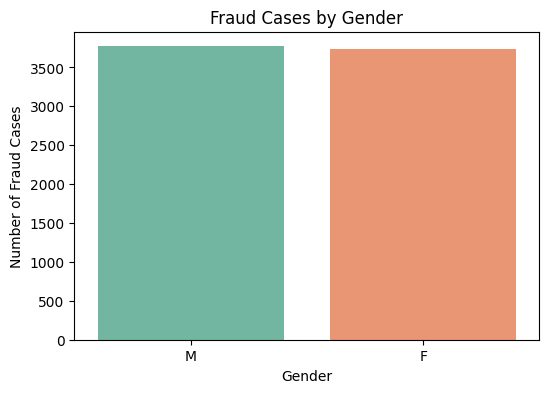

In [7]:
# Count fraud cases by gender
gender_fraud = df[df['is_fraud'] == 1]['gender'].value_counts().reset_index()
gender_fraud.columns = ['Gender', 'Fraud_Count']

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Gender', y='Fraud_Count', data=gender_fraud, palette='Set2')
plt.title("Fraud Cases by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Fraud Cases")
plt.show()

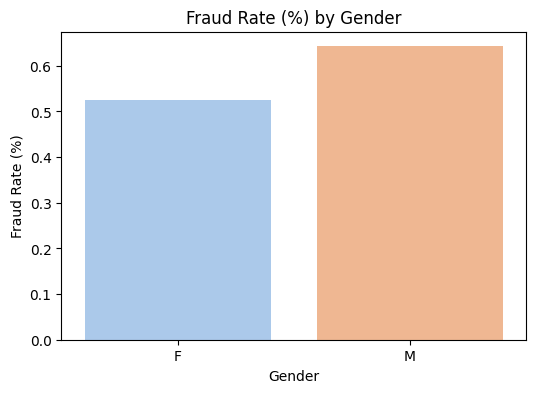

In [8]:
# Total transactions by gender
gender_total = df['gender'].value_counts().reset_index()
gender_total.columns = ['Gender', 'Total_Transactions']
# Fraud transactions by gender
gender_fraud = df[df['is_fraud'] == 1]['gender'].value_counts().reset_index()
gender_fraud.columns = ['Gender', 'Fraud_Count']
# Merge
result = pd.merge(gender_total, gender_fraud, on='Gender')
result['Fraud_Rate (%)'] = (result['Fraud_Count'] / result['Total_Transactions']) * 100
# Plot fraud rate
plt.figure(figsize=(6,4))
sns.barplot(x='Gender', y='Fraud_Rate (%)', data=result, palette='pastel')
plt.title("Fraud Rate (%) by Gender")
plt.xlabel("Gender")
plt.ylabel("Fraud Rate (%)")
plt.show()


/tmp/ipykernel_36/1530560557.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df.groupby('age_group').agg(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


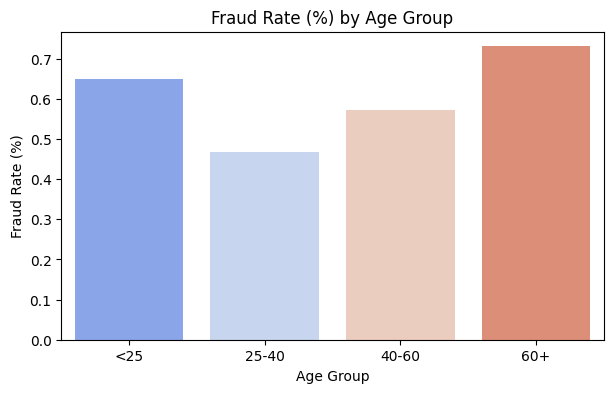

In [9]:
# Convert dob to age
df['dob'] = pd.to_datetime(df['dob'])
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year)
# Define age bins
bins = [0, 25, 40, 60, 100]
labels = ['<25', '25-40', '40-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
# Fraud rate by age group
age_stats = df.groupby('age_group').agg(
    Total_Transactions=('is_fraud','count'),
    Fraud_Count=('is_fraud','sum')
).reset_index()
age_stats['Fraud_Rate (%)'] = (age_stats['Fraud_Count'] / age_stats['Total_Transactions']) * 100
# Plot
plt.figure(figsize=(7,4))
sns.barplot(x='age_group', y='Fraud_Rate (%)', data=age_stats, palette='coolwarm')
plt.title("Fraud Rate (%) by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Fraud Rate (%)")
plt.show()


/tmp/ipykernel_36/1604042492.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combo_stats = df.groupby(['age_group', 'gender']).agg(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.gro

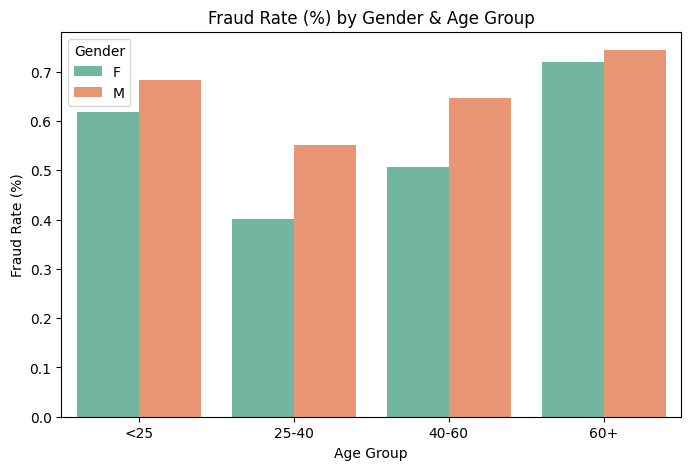

In [10]:
# Fraud rate by gender and age group
combo_stats = df.groupby(['age_group', 'gender']).agg(
    Total_Transactions=('is_fraud','count'),
    Fraud_Count=('is_fraud','sum')
).reset_index()
combo_stats['Fraud_Rate (%)'] = (combo_stats['Fraud_Count'] / combo_stats['Total_Transactions']) * 100
# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='Fraud_Rate (%)', hue='gender', data=combo_stats, palette='Set2')
plt.title("Fraud Rate (%) by Gender & Age Group")
plt.xlabel("Age Group")
plt.ylabel("Fraud Rate (%)")
plt.legend(title="Gender")
plt.show()


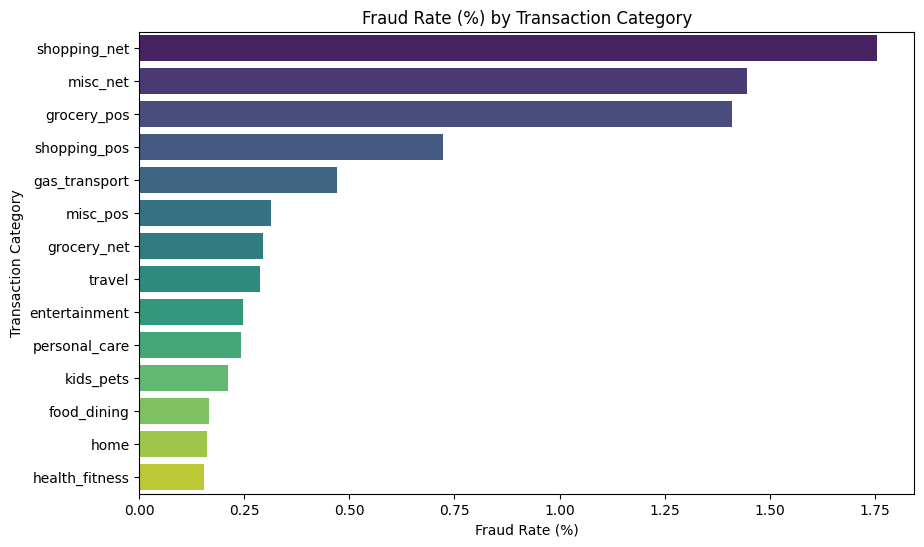

In [11]:
# Fraud rate by transaction category
cat_stats = df.groupby('category').agg(
    Total_Transactions=('is_fraud','count'),
    Fraud_Count=('is_fraud','sum')
).reset_index()
cat_stats['Fraud_Rate (%)'] = (cat_stats['Fraud_Count'] / cat_stats['Total_Transactions']) * 100
# Sort by fraud rate
cat_stats = cat_stats.sort_values(by='Fraud_Rate (%)', ascending=False)
# Plot fraud rate
plt.figure(figsize=(10,6))
sns.barplot(x='Fraud_Rate (%)', y='category', data=cat_stats, palette='viridis')
plt.title("Fraud Rate (%) by Transaction Category")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Transaction Category")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


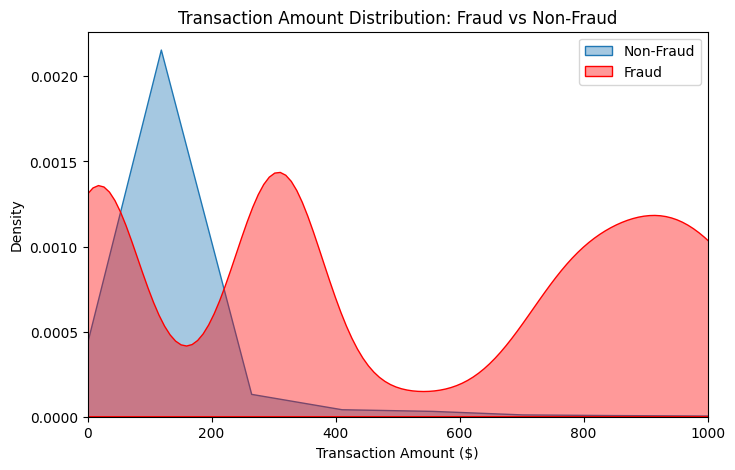

In [12]:
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df[df['is_fraud']==0]['amt'], 
    label='Non-Fraud', 
    fill=True, 
    alpha=0.4
)
sns.kdeplot(
    data=df[df['is_fraud']==1]['amt'], 
    label='Fraud', 
    fill=True, 
    alpha=0.4, 
    color='red'
)
plt.xlim(0, 1000)  # adjust if you have very large outliers
plt.xlabel("Transaction Amount ($)")
plt.ylabel("Density")
plt.title("Transaction Amount Distribution: Fraud vs Non-Fraud")
plt.legend()
plt.show()


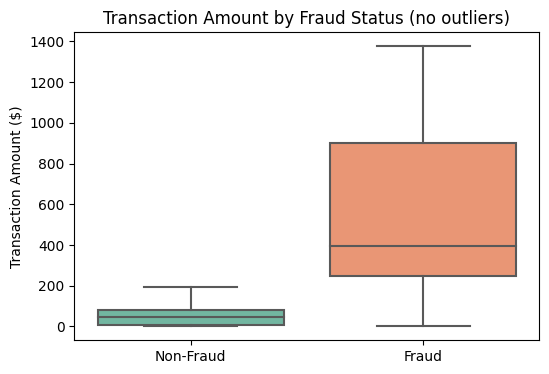

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x='is_fraud', y='amt', data=df, palette='Set2', showfliers=False)
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.xlabel("")
plt.ylabel("Transaction Amount ($)")
plt.title("Transaction Amount by Fraud Status (no outliers)")
plt.show()

/tmp/ipykernel_36/536233286.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_stats = df.groupby('amt_bin').agg(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


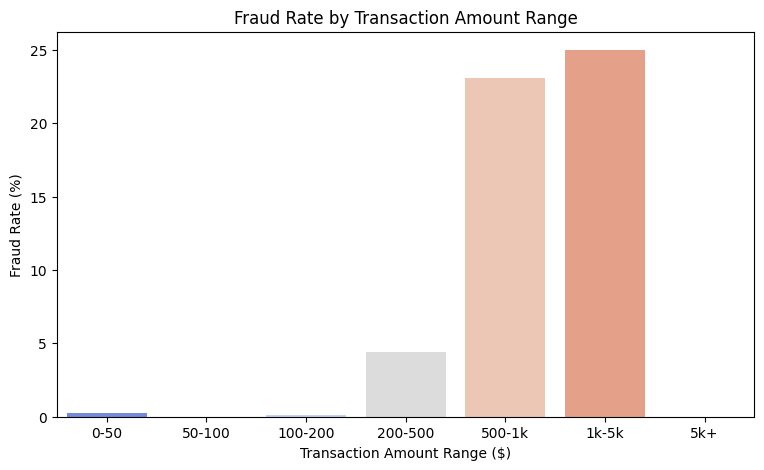

In [14]:
bins = [0,50,100,200,500,1000,5000,10000]
labels = ['0-50','50-100','100-200','200-500','500-1k','1k-5k','5k+']
df['amt_bin'] = pd.cut(df['amt'], bins=bins, labels=labels, right=False)

amt_stats = df.groupby('amt_bin').agg(
    Total=('is_fraud','count'),
    Fraud=('is_fraud','sum')
).reset_index()
amt_stats['Fraud_Rate (%)'] = (amt_stats['Fraud'] / amt_stats['Total']) * 100
plt.figure(figsize=(9,5))
sns.barplot(x='amt_bin', y='Fraud_Rate (%)', data=amt_stats, palette='coolwarm')
plt.xlabel("Transaction Amount Range ($)")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Transaction Amount Range")
plt.show()


Non-fraud stats: {'count': 1289169, 'mean': 67.66710981260022, 'median': 47.28, 'std': 154.00797054609953, 'min': 1.0, '25%': 9.61, '75%': 82.54, '90%': 134.21, '99%': 486.3032000000007, 'max': 28948.9}
Fraud stats: {'count': 7506, 'mean': 531.3200919264589, 'median': 396.505, 'std': 390.560069725536, 'min': 1.06, '25%': 245.6625, '75%': 900.875, '90%': 1024.5949999999998, '99%': 1179.6899999999996, 'max': 1376.04}
Fraction of fraud transactions with amt < 10: 0.0699
Fraction of fraud transactions with amt < 50: 0.2141
Fraction of fraud transactions with amt < 100: 0.2201
Fraction of fraud transactions with amt < 200: 0.2401
Fraction of fraud transactions with amt < 500: 0.5140
Non-fraud KDE mode candidates: [  7.50002161  57.00016424 481.50138741 665.25191688 723.75208544]
Fraud KDE mode candidates: [ 18.75005403 308.2508882  913.5026322 ]
Symmetric KDE overlap area (0..1): 0.2086
KS test: statistic=0.7265, p-value=0


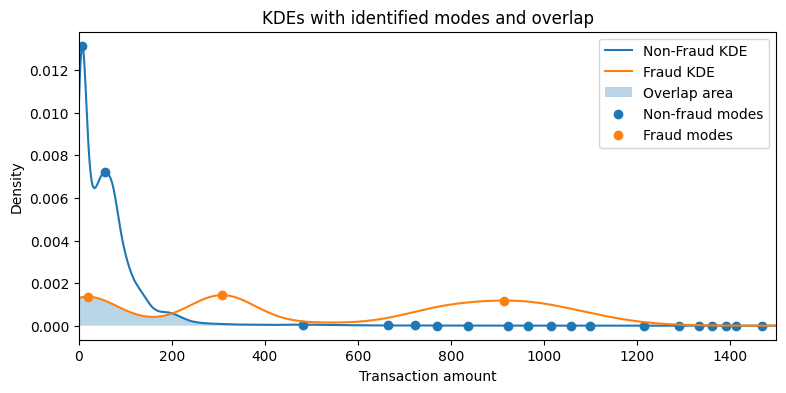

In [15]:
# split amounts
amt_nonfraud = df.loc[df['is_fraud'] == 0, 'amt'].dropna().values
amt_fraud = df.loc[df['is_fraud'] == 1, 'amt'].dropna().values
#Basic descriptive stats
def desc_stats(arr):
    return {
        'count': len(arr),
        'mean': float(np.mean(arr)),
        'median': float(np.median(arr)),
        'std': float(np.std(arr, ddof=1)),
        'min': float(np.min(arr)),
        '25%': float(np.percentile(arr, 25)),
        '75%': float(np.percentile(arr, 75)),
        '90%': float(np.percentile(arr, 90)),
        '99%': float(np.percentile(arr, 99)),
        'max': float(np.max(arr))
    }
stats_non = desc_stats(amt_nonfraud)
stats_fraud = desc_stats(amt_fraud)
print("Non-fraud stats:", stats_non)
print("Fraud stats:", stats_fraud)
#Fraction of fraud transactions below/above thresholds
thresholds = [10, 50, 100, 200, 500]
for t in thresholds:
    frac_below = (amt_fraud < t).sum() / len(amt_fraud)
    print(f"Fraction of fraud transactions with amt < {t}: {frac_below:.4f}")
# KDE-based peaks (modes)
# build a grid across a sensible range (clamp to avoid huge tails)
x_min = 0
x_max = np.percentile(np.concatenate([amt_nonfraud, amt_fraud]), 99.9)
x = np.linspace(x_min, x_max, 2000)
kde_non = stats.gaussian_kde(amt_nonfraud)
kde_fraud = stats.gaussian_kde(amt_fraud)
dens_non = kde_non(x)
dens_fraud = kde_fraud(x)
# find peaks in density curves
peaks_non, _ = find_peaks(dens_non)
peaks_fraud, _ = find_peaks(dens_fraud)
modes_non = x[peaks_non]
modes_fraud = x[peaks_fraud]
print("Non-fraud KDE mode candidates:", modes_non[:5])
print("Fraud KDE mode candidates:", modes_fraud[:5])
# Overlap area between KDEs (0..1). 0 = no overlap, 1 = identical
overlap = np.trapz(np.minimum(dens_non, dens_fraud), x) / np.trapz(dens_non, x)  # normalized by non-fraud area (~1)
# better symmetric overlap estimate:
sym_overlap = np.trapz(np.minimum(dens_non, dens_fraud), x)
print(f"Symmetric KDE overlap area (0..1): {sym_overlap:.4f}")
# Statistical test to test distributional difference
ks_stat, ks_p = stats.ks_2samp(amt_nonfraud, amt_fraud)
print(f"KS test: statistic={ks_stat:.4f}, p-value={ks_p:.4g}")
plt.figure(figsize=(9,4))
plt.plot(x, dens_non, label='Non-Fraud KDE')
plt.plot(x, dens_fraud, label='Fraud KDE')
plt.fill_between(x, np.minimum(dens_non, dens_fraud), alpha=0.3, label='Overlap area')
plt.scatter(modes_non, kde_non(modes_non), marker='o', color='C0', label='Non-fraud modes')
plt.scatter(modes_fraud, kde_fraud(modes_fraud), marker='o', color='C1', label='Fraud modes')
plt.xlim(x_min, x_max)
plt.legend()
plt.xlabel('Transaction amount')
plt.ylabel('Density')
plt.title('KDEs with identified modes and overlap')
plt.show()


In [16]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,age_group,amt_bin
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,31,25-40,0-50
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,41,40-60,100-200
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,57,40-60,200-500
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,52,40-60,0-50
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,33,25-40,0-50


# TIME BASED FEATURES

In [18]:
# --- Ensure datetime columns ---
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])


In [19]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [20]:
# Time since last transaction (per user)
df = df.sort_values(by=['cc_num','trans_date_trans_time'])
df['time_since_last'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds().fillna(0)


In [21]:
# Transaction frequency in past 1 hour
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
# Sort before grouping
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
# Define a function to compute rolling counts
def rolling_count_last_hour(group):
    # Set datetime as index for rolling
    group = group.set_index('trans_date_trans_time')
    # Count transactions within the past 1 hour window
    group['trans_count_1h'] = group['cc_num'].rolling('1h').count()
    # Reset index to keep the same structure
    return group.reset_index()
# Apply per user/card group
df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_hour)

/tmp/ipykernel_36/425114082.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_hour)


In [22]:
# Compute geo distance (user vs merchant)
df['distance_km'] = df.apply(
    lambda row: geodesic((row['lat'], row['long']),
                         (row['merch_lat'], row['merch_long'])).km,
    axis=1
)

# Mark as same_state if within ~50 km
df['same_state'] = (df['distance_km'] < 50).astype(int)


# AMOUNT BASED FEATURE

In [23]:
df['log_amt'] = np.log1p(df['amt'])
# Relative amount (vs customer mean)
df['avg_amt_user'] = df.groupby('cc_num')['amt'].transform('mean')
df['relative_amt'] = df['amt'] / (df['avg_amt_user'] + 1e-5)
# High-value flag (e.g., > 95th percentile)
threshold = df['amt'].quantile(0.95)
df['high_value'] = (df['amt'] > threshold).astype(int)

# DEMOGRAPHIC FEATURE

In [24]:
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
# Age group
df['age_group'] = pd.cut(df['age'], bins=[0,25,40,60,120], labels=['<25','25-40','40-60','60+'])
# Occupation risk category (simplified example)
risky_jobs = ['student','retired','unemployed']
df['job_risk'] = df['job'].apply(lambda x: 1 if str(x).lower() in risky_jobs else 0)
$City population group
df['city_pop_group'] = pd.cut(df['city_pop'], 
                              bins=[0,50000,200000,1000000,1e10], 
                              labels=['rural','small_city','city','metro'])

# BEHAVRIOUL FEATURE

In [25]:
# Number of unique merchants visited
df['unique_merchants'] = df.groupby('cc_num')['merchant'].transform('nunique')

In [26]:
df['user_avg_amt'] = df.groupby('cc_num')['amt'].transform('mean')

In [27]:
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
# Define function for rolling 7-day transaction count
def rolling_count_last_7d(group):
    group = group.set_index('trans_date_trans_time')
    group['trans_count_7d'] = group['cc_num'].rolling('7d').count()
    return group.reset_index()
df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_7d)

/tmp/ipykernel_36/3628543483.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_7d)


In [28]:
# Merchant diversity (unique merchants / total transactions)
df['merchant_diversity'] = df['unique_merchants'] / df.groupby('cc_num')['merchant'].transform('count')


# CATEGORICAL FEATURES


In [29]:
categorical_cols = ['merchant','category','state','job']
for col in categorical_cols:
    le = LabelEncoder()
    df[col+'_encoded'] = le.fit_transform(df[col].astype(str))
for col in categorical_cols:
    freq_enc = df[col].value_counts().to_dict()
    df[col+'_freq'] = df[col].map(freq_enc)
print("New features created:", df.columns)

New features created: Index(['trans_date_trans_time', 'Unnamed: 0', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'age_group', 'amt_bin',
       'hour', 'day_of_week', 'is_weekend', 'time_since_last',
       'trans_count_1h', 'distance_km', 'same_state', 'log_amt',
       'avg_amt_user', 'relative_amt', 'high_value', 'job_risk',
       'city_pop_group', 'unique_merchants', 'user_avg_amt', 'trans_count_7d',
       'merchant_diversity', 'merchant_encoded', 'category_encoded',
       'state_encoded', 'job_encoded', 'merchant_freq', 'category_freq',
       'state_freq', 'job_freq'],
      dtype='object')


In [30]:
df.head()

,trans_date_trans_time,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,...,trans_count_7d,merchant_diversity,merchant_encoded,category_encoded,state_encoded,job_encoded,merchant_freq,category_freq,state_freq,job_freq
0,2019-01-01 12:47:15,1017,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,1.0,0.378788,293,8,50,246,1269,63287,19322,2021
1,2019-01-02 08:44:57,2724,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,2.0,0.378788,43,2,50,246,2677,131659,19322,2021
2,2019-01-02 08:47:36,2726,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,3.0,0.378788,399,2,50,246,2630,131659,19322,2021
3,2019-01-02 12:38:14,2882,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,4.0,0.378788,126,7,50,246,2230,113035,19322,2021
4,2019-01-02 13:10:46,2907,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,5.0,0.378788,41,6,50,246,2473,123115,19322,2021


In [32]:
df.head()

,trans_date_trans_time,Unnamed: 0,cc_num,merchant,category,amt,first,last,gender,street,...,trans_count_7d,merchant_diversity,merchant_encoded,category_encoded,state_encoded,job_encoded,merchant_freq,category_freq,state_freq,job_freq
0,2019-01-01 12:47:15,1017,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,1.0,0.378788,293,8,50,246,1269,63287,19322,2021
1,2019-01-02 08:44:57,2724,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,2.0,0.378788,43,2,50,246,2677,131659,19322,2021
2,2019-01-02 08:47:36,2726,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,3.0,0.378788,399,2,50,246,2630,131659,19322,2021
3,2019-01-02 12:38:14,2882,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,4.0,0.378788,126,7,50,246,2230,113035,19322,2021
4,2019-01-02 13:10:46,2907,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,5.0,0.378788,41,6,50,246,2473,123115,19322,2021


In [33]:
cols_to_keep = [
    'log_amt', 'hour', 'day_of_week', 'time_since_last',
    'trans_count_1h', 'trans_count_7d',
    'age', 'gender',
    'distance_km', 'same_state', 'city_pop_group',
    'merchant_diversity', 'unique_merchants',
    'merchant_encoded', 'category_encoded', 'state_encoded', 'job_encoded',
    'job_risk', 'avg_amt_user',
    'is_fraud'
]

df_model = df[cols_to_keep]
print(df_model.columns)


Index(['log_amt', 'hour', 'day_of_week', 'time_since_last', 'trans_count_1h',
       'trans_count_7d', 'age', 'gender', 'distance_km', 'same_state',
       'city_pop_group', 'merchant_diversity', 'unique_merchants',
       'merchant_encoded', 'category_encoded', 'state_encoded', 'job_encoded',
       'job_risk', 'avg_amt_user', 'is_fraud'],
      dtype='object')


In [34]:
df_model_c = df_model.copy()

In [35]:
le = LabelEncoder()
df_model['gender'] = le.fit_transform(df_model['gender'])

/tmp/ipykernel_36/483068064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['gender'] = le.fit_transform(df_model['gender'])


In [36]:
df_model['city_pop_group'] = le.fit_transform(df_model['city_pop_group'])

/tmp/ipykernel_36/3369437813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['city_pop_group'] = le.fit_transform(df_model['city_pop_group'])


In [37]:
df_model['city_pop_group'].unique()

array([2, 0, 1, 3])

In [38]:
df_model.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   log_amt             1296675 non-null  float64
 1   hour                1296675 non-null  int32  
 2   day_of_week         1296675 non-null  int32  
 3   time_since_last     1296675 non-null  float64
 4   trans_count_1h      1296675 non-null  float64
 5   trans_count_7d      1296675 non-null  float64
 6   age                 1296675 non-null  int32  
 7   gender              1296675 non-null  int64  
 8   distance_km         1296675 non-null  float64
 9   same_state          1296675 non-null  int64  
 10  city_pop_group      1296675 non-null  int64  
 11  merchant_diversity  1296675 non-null  float64
 12  unique_merchants    1296675 non-null  int64  
 13  merchant_encoded    1296675 non-null  int64  
 14  category_encoded    1296675 non-null  int64  
 15  state_encoded       129

In [39]:
df_model.head()

,log_amt,hour,day_of_week,time_since_last,trans_count_1h,trans_count_7d,age,gender,distance_km,same_state,city_pop_group,merchant_diversity,unique_merchants,merchant_encoded,category_encoded,state_encoded,job_encoded,job_risk,avg_amt_user,is_fraud
0,2.112635,12,1,0.0,1.0,1.0,33,0,127.629296,0,2,0.378788,575,293,8,50,246,0,56.023366,0
1,3.987872,8,2,71862.0,1.0,2.0,33,0,110.202992,0,2,0.378788,575,43,2,50,246,0,56.023366,0
2,4.419804,8,2,159.0,2.0,3.0,33,0,21.841827,1,2,0.378788,575,399,2,50,246,0,56.023366,0
3,3.577669,12,2,13838.0,1.0,4.0,33,0,87.124420,0,2,0.378788,575,126,7,50,246,0,56.023366,0
4,3.338613,13,2,1952.0,2.0,5.0,33,0,74.352876,0,2,0.378788,575,41,6,50,246,0,56.023366,0


is_fraud
0    1289169
1       7506
Name: count, dtype: int64


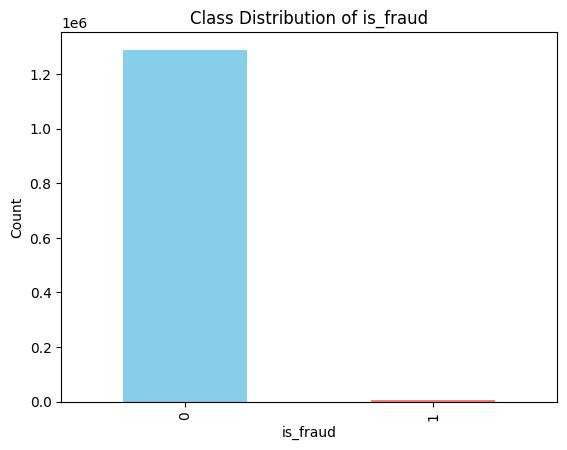

In [40]:
class_counts = df_model['is_fraud'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of is_fraud')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.show()


In [17]:
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# OVERSAMPLING

In [41]:
df_majority = df_model[df_model['is_fraud'] == 0]
df_minority = df_model[df_model['is_fraud'] == 1]
n_to_add = len(df_majority) - len(df_minority)
df_minority_oversampled = df_minority.sample(n=n_to_add, replace=True, random_state=42)
df_balanced = pd.concat([df_majority, df_minority, df_minority_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['is_fraud'].value_counts())


is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


In [42]:

X = df_balanced.drop('is_fraud', axis=1)
y = df_balanced['is_fraud']
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
lr = LogisticRegression(max_iter=1000, solver='saga')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy:", acc)


Confusion Matrix:
[[220844  36990]
 [ 50978 206856]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83    257834
           1       0.85      0.80      0.82    257834

    accuracy                           0.83    515668
   macro avg       0.83      0.83      0.83    515668
weighted avg       0.83      0.83      0.83    515668


Accuracy: 0.8294096201431929


In [43]:
lr = LogisticRegression(max_iter=1000, solver='saga')

# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],          
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.5, 1]            
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',        
    cv=3,                
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_

Best Parameters: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'l2'}
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83    257834
           1       0.85      0.80      0.82    257834

    accuracy                           0.83    515668
   macro avg       0.83      0.83      0.83    515668
weighted avg       0.83      0.83      0.83    515668



In [44]:
dt = DecisionTreeClassifier(
    max_depth=10,         
    min_samples_split=50,  
    random_state=42
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy:", acc)

Confusion Matrix:
[[251301   6533]
 [  3107 254727]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    257834
           1       0.97      0.99      0.98    257834

    accuracy                           0.98    515668
   macro avg       0.98      0.98      0.98    515668
weighted avg       0.98      0.98      0.98    515668


Accuracy: 0.9813058014071069


In [45]:
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [25, 50, 100],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',  # optimize for F1-score
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 25, 'min_samples_split': 50}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257834
           1       0.99      1.00      1.00    257834

    accuracy                           1.00    515668
   macro avg       1.00      1.00      1.00    515668
weighted avg       1.00      1.00      1.00    515668



In [46]:
# Decision Tree with our best hyperparameters
dt_best = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=25,
    min_samples_split=50,
    random_state=42
)
cv_scores = cross_val_score(
    dt_best,
    X_train,  # training data only
    y_train,
    cv=50,
    scoring='accuracy',
    n_jobs=-1
)
mean_acc = np.mean(cv_scores)
std_acc = np.std(cv_scores)
print(f"Cross-validated Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

Cross-validated Accuracy: 99.71% ± 0.03%


In [47]:
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=15,           # limit tree depth to reduce overfitting
    min_samples_split=50,   # minimum samples to split a node
    min_samples_leaf=25,    # minimum samples per leaf
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print("\nAccuracy:", acc)


Confusion Matrix:
[[256788   1046]
 [   921 256913]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       1.00      1.00      1.00    257834

    accuracy                           1.00    515668
   macro avg       1.00      1.00      1.00    515668
weighted avg       1.00      1.00      1.00    515668


Accuracy: 0.9961855302248733


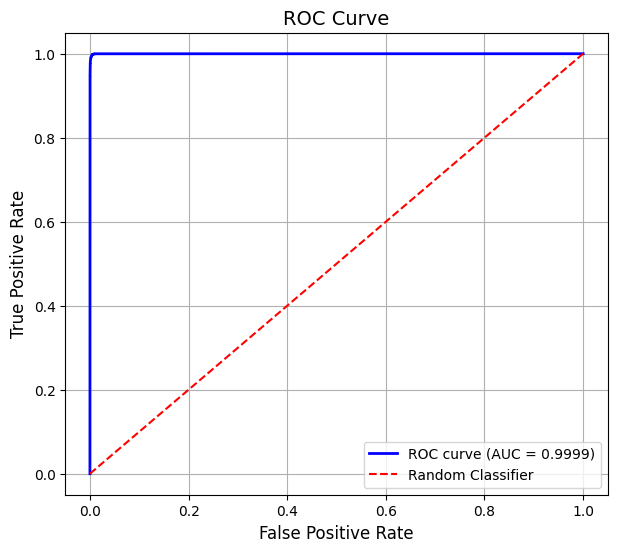

AUC Score: 0.9999


In [48]:
y_prob = rf.predict_proba(X_test)[:, 1]
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
# Plot ROC Curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print(f"AUC Score: {roc_auc:.4f}")


NameError: name 'dt_best' is not defined